In [5]:
 import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr

PSFD-Musa DATASET

In [7]:
data_dir = 'D:/archive/BananaDisease2nddata'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 7571 images belonging to 3 classes.
Found 1892 images belonging to 3 classes.


In [9]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [11]:
class_weights

{0: 2.0618191721132897, 1: 0.6101708575112831, 2: 1.1414141414141414}

Found 9463 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0714155].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.29982516..1.0563447].


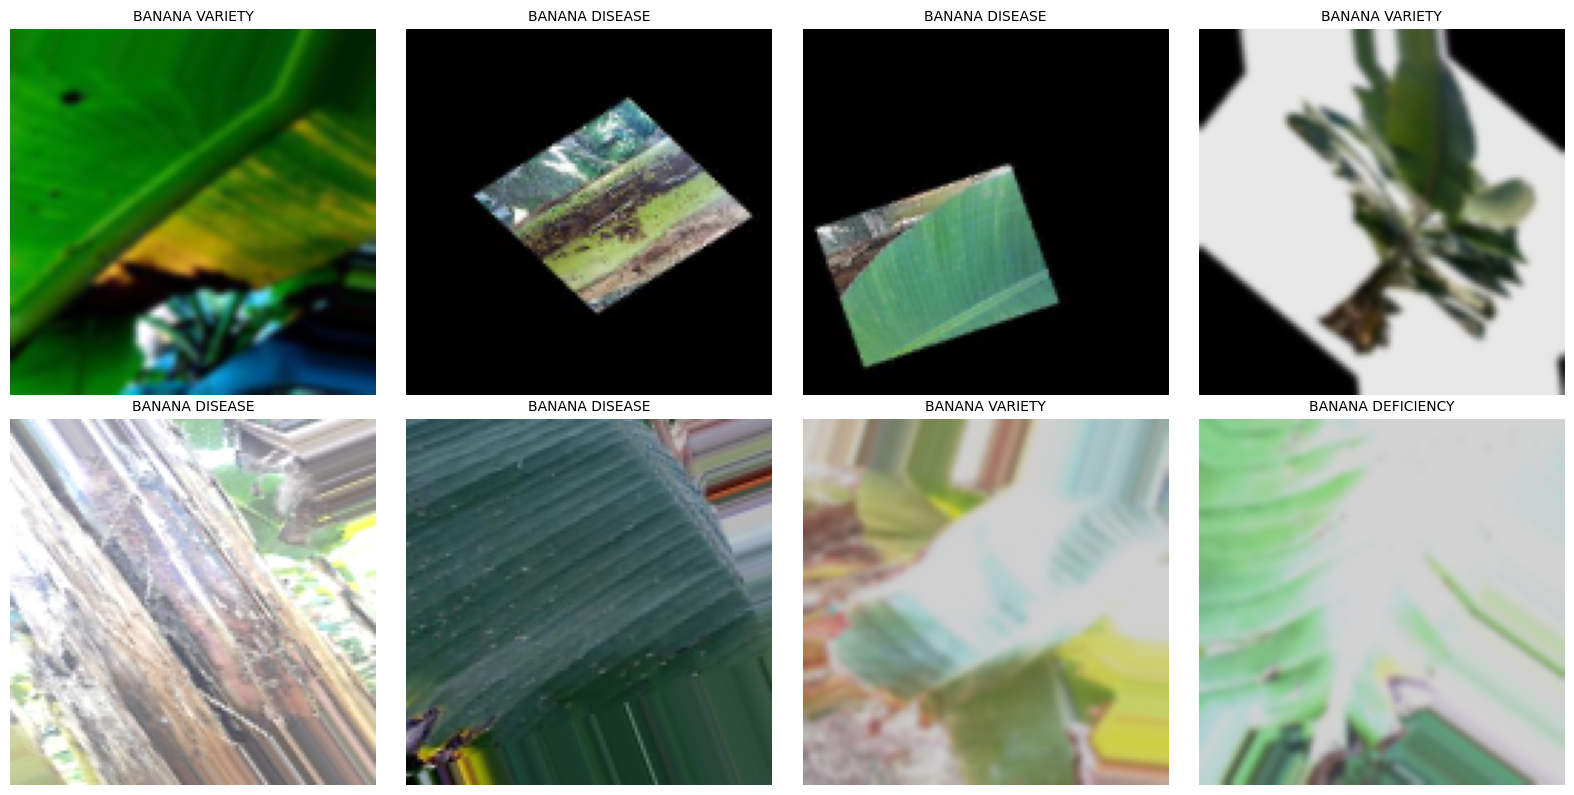

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from imgaug import augmenters as iaa

# Function for custom augmentation (Gaussian blur, Linear contrast, etc.)
def custom_augment(image):
    # Convert to numpy array
    image = np.array(image)
    
    # Gaussian Blur
    if np.random.rand() > 0.5:  # Apply with 50% probability
        image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Linear Contrast
    if np.random.rand() > 0.5:  # Apply with 50% probability
        contrast = iaa.LinearContrast((0.75, 1.5))  # Random contrast adjustment
        image = contrast.augment_image(image)

    return image

# Define the ImageDataGenerator with standard augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Random rotations
    width_shift_range=0.2,  # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=20,         # Shear transformation
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Horizontal flip
    fill_mode='nearest'     # Filling strategy for new pixels
)

# Example: Custom augmentation for one batch
def augment_and_display(data_dir):
    # Load and augment images
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=(128, 128),  # Resize images
        batch_size=8,           # Generate 8 images for visualization
        class_mode='categorical'  # Include labels
    )
    
    # Get one batch of images and labels
    images, labels = next(generator)
    augmented_images = [custom_augment(img) for img in images]
    
    # Get class labels
    class_indices = generator.class_indices
    label_map = {v: k for k, v in class_indices.items()}  # Map indices to class names
    label_names = [label_map[np.argmax(lbl)] for lbl in labels]
    
    # Plot original and augmented images with labels
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    for img, label, ax in zip(augmented_images, label_names, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label, fontsize=10)  # Set label as title
    plt.tight_layout()
    plt.show()

# Replace 'data_dir' with the path to your dataset
augment_and_display("D:/archive/BananaDisease2nddata")


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Concatenate,
    GlobalAveragePooling2D,
    BatchNormalization,
    Activation,
    Flatten,
    Dense
)
from tensorflow.keras.models import Model


def fire_module(x, squeeze_filters, expand_filters):
    """
    A Fire module with squeeze and expand operations.

    Args:
        x: Input tensor.
        squeeze_filters: Number of filters for the squeeze layer.
        expand_filters: Number of filters for the expand layer.

    Returns:
        Output tensor after the fire module.
    """
    # Squeeze operation
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='valid')(x)
    squeeze = BatchNormalization()(squeeze)

    # Expand operation
    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='valid')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)

    # Concatenate the 1x1 and 3x3 expansions
    output = Concatenate()([expand_1x1, expand_3x3])
    output = BatchNormalization()(output)

    return output


def build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=4):
    """
    Builds the Improved SqueezeNet model.

    Args:
        input_shape: Shape of the input images (default is (128, 128, 3)).
        num_classes: Number of output classes.

    Returns:
        A compiled SqueezeNet model.
    """
    input_layer = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = Dropout(0.5)(x)  # Regularization

    # Output layers
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Activation('softmax')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Example usage
if __name__ == "__main__":
    # Define model
    model = build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=4)

    # Display model architecture
    model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 64, 64, 96)        │           2,688 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 96)        │             384 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 32, 32, 96)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 16)        │           1,552 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 16)        │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 32, 32, 128)       │               0 │ conv2d_2[0][0],            │
│                               │                           │                 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 32, 128)       │             512 │ concatenate[0][0]          │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 16)        │           2,064 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 32, 32, 16)        │              64 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 32, 32, 128)       │               

 Total params: 737,876 (2.81 MB)

 Trainable params: 731,916 (2.79 MB)

 Non-trainable params: 5,960 (23.28 KB)

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Build the Improved SqueezeNet model
model_squeezenet = build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=3)

# Display the model summary
model_squeezenet.summary()

# Create sample data generators
# Note: Replace these paths with actual data directories
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Sample data (replace paths with actual directories)
train_generator = train_datagen.flow_from_directory(
    'D:/archive/BananaLSD/AugmentedSet',  # Replace with your training data path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'D:/archive/BananaLSD/AugmentedSet',  # Replace with your validation data path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Compile the model
model_squeezenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_squeezenet = model_squeezenet.fit(
    train_generator,
    epochs=15,  # For demonstration, adjust as needed
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_squeezenet.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_squeezenet.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Improved SqueezeNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_squeezenet.history['loss'], label='Training Loss', marker='o')
plt.plot(history_squeezenet.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Improved SqueezeNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_130 (Conv2D)           │ (None, 64, 64, 96)        │           2,688 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_90        │ (None, 64, 64, 96)        │             384 │ conv2d_130[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_15              │ (None, 32, 32, 96)        │               0 │ batch_normalization_90[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_131 (Conv2D)           │ (None, 32, 32, 16)        │           1,552 │ max_pooling2d_15[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_91        │ (None, 32, 32, 16)        │              64 │ conv2d_131[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_132 (Conv2D)           │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_91[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_133 (Conv2D)           │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_91[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_40 (Concatenate)  │ (None, 32, 32, 128)       │               0 │ conv2d_132[0][0],          │
│                               │                           │                 │ conv2d_133[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_92        │ (None, 32, 32, 128)       │             512 │ concatenate_40[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_134 (Conv2D)           │ (None, 32, 32, 16)        │           2,064 │ batch_normalization_92[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_93        │ (None, 32, 32, 16)        │              64 │ conv2d_134[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_135 (Conv2D)           │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_93[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_136 (Conv2D)           │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_93[0]… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 737,359 (2.81 MB)

 Trainable params: 731,401 (2.79 MB)

 Non-trainable params: 5,958 (23.27 KB)

Found 1600 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.
Epoch 1/15


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 4), output.shape=(None, 3)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_104 (Conv2D)           │ (None, 64, 64, 96)        │           2,688 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_72        │ (None, 64, 64, 96)        │             384 │ conv2d_104[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_12              │ (None, 32, 32, 96)        │               0 │ batch_normalization_72[0]… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_105 (Conv2D)           │ (None, 32, 32, 16)        │           1,552 │ max_pooling2d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_73        │ (None, 32, 32, 16)        │              64 │ conv2d_105[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_106 (Conv2D)           │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_73[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_107 (Conv2D)           │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_73[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_32 (Concatenate)  │ (None, 32, 32, 128)       │               0 │ conv2d_106[0][0],          │
│                               │                           │                 │ conv2d_107[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_74        │ (None, 32, 32, 128)       │             512 │ concatenate_32[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_108 (Conv2D)           │ (None, 32, 32, 16)        │           2,064 │ batch_normalization_74[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_75        │ (None, 32, 32, 16)        │              64 │ conv2d_108[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_109 (Conv2D)           │ (None, 32, 32, 64)        │           1,088 │ batch_normalization_75[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_110 (Conv2D)           │ (None, 32, 32, 64)        │           9,280 │ batch_normalization_75[0]… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 737,359 (2.81 MB)

 Trainable params: 731,401 (2.79 MB)

 Non-trainable params: 5,958 (23.27 KB)

Found 9463 images belonging to 3 classes.
Found 9463 images belonging to 3 classes.
Epoch 1/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - accuracy: 0.6709 - loss: 0.8095 - val_accuracy: 0.1815 - val_loss: 2.3175
Epoch 2/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.8145 - loss: 0.5347 - val_accuracy: 0.4919 - val_loss: 2.2313
Epoch 3/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 602s 2s/step - accuracy: 0.8539 - loss: 0.4252 - val_accuracy: 0.6705 - val_loss: 0.8557
Epoch 4/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.8669 - loss: 0.3732 - val_accuracy: 0.8070 - val_loss: 0.5165
Epoch 5/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 866s 3s/step - accuracy: 0.8794 - loss: 0.3413 - val_accuracy: 0.8328 - val_loss: 0.4672
Epoch 6/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.8862 - loss: 0.3229 - val_accuracy: 0.7745 - val_loss: 0.5829
Epoch 7/15
296/296 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.8968 - loss: 0.2996 - val_accuracy: 0.8839 - val_loss: 0.3305
Epoch 8/15
29

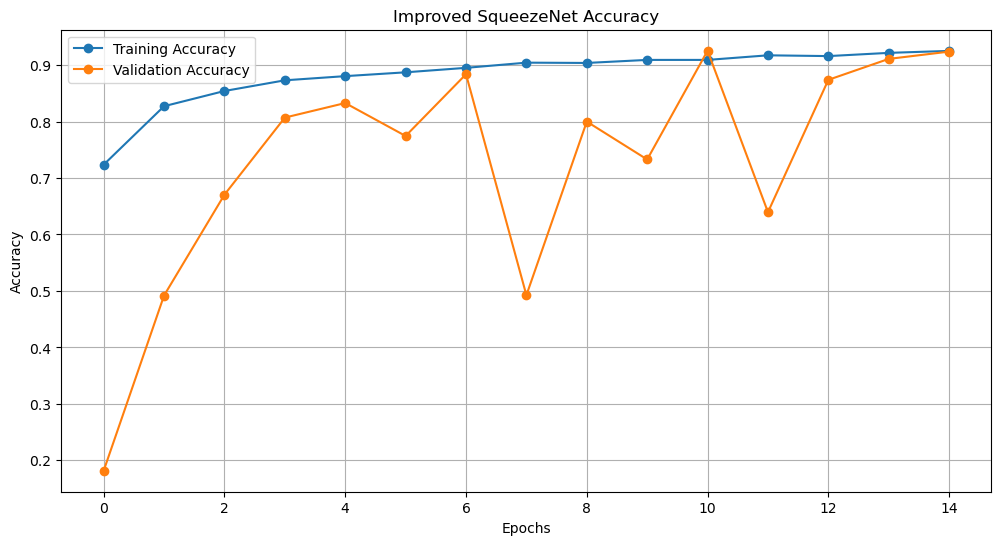

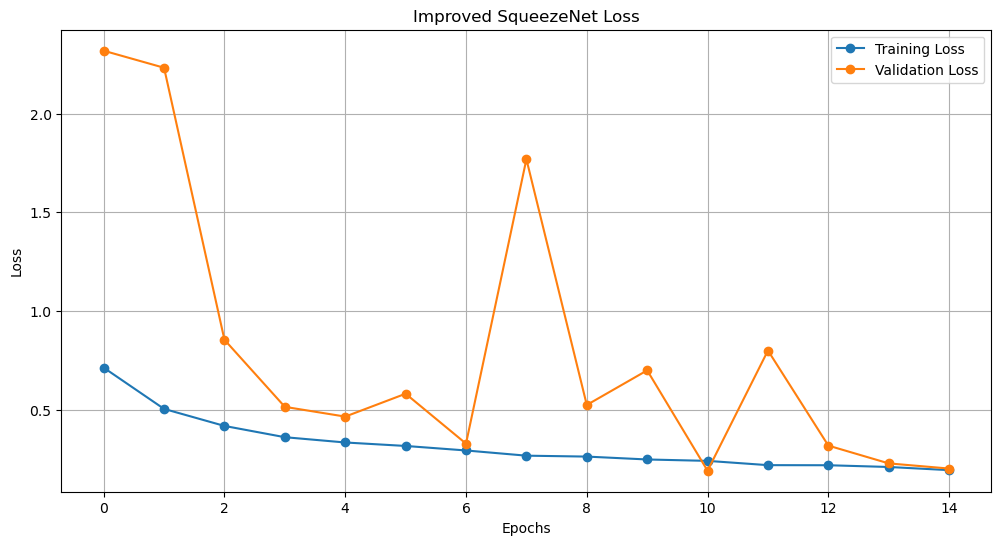

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Build the Improved SqueezeNet model
model_squeezenet = build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=3)

# Display the model summary
model_squeezenet.summary()

# Create sample data generators
# Note: Replace these paths with actual data directories
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Sample data (replace paths with actual directories)
train_generator = train_datagen.flow_from_directory(
    'D:/archive/BananaDisease2nddata',  # Replace with your training data path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'D:/archive/BananaDisease2nddata',  # Replace with your validation data path
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Compile the model
model_squeezenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_squeezenet = model_squeezenet.fit(
    train_generator,
    epochs=15,  # For demonstration, adjust as needed
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_squeezenet.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_squeezenet.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Improved SqueezeNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_squeezenet.history['loss'], label='Training Loss', marker='o')
plt.plot(history_squeezenet.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Improved SqueezeNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
